In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from time import time
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import ccf, adfuller

data_folder = Path('./../../data/')

## (I) Load Data (Crypto / Tweets/ Market)
Some coins other than BTC and ETH are included. Future experimentation could involve using a large number of coins and performing separate feature extraction on that dataset.

In [2]:
coin_names = ['BTC', 'ETH', 'SOL', 'LINK', 'USDC']
dct_coin_tables = {}
for suffix in coin_names:
    dct_coin_tables[suffix] = pd.read_csv(Path(data_folder / 'coin_index_vals_merged_{}.csv'.format(suffix)), parse_dates=['date'])

print(dct_coin_tables.keys())

df_bitcoin = dct_coin_tables['BTC'] # A view to a table for inspection because VScode Jupyter dict inspection is a catastrophe.
print(df_bitcoin.columns)

dict_keys(['BTC', 'ETH', 'SOL', 'LINK', 'USDC'])
Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume USD',
       'Volume BTC', 'close_ETH', 'close_SOL', 'close_UST', 'open_SP500',
       'high_SP500', 'low_SP500', 'close_SP500', 'volume_SP500', 'open_NSDQ_x',
       'high_NSDQ_x', 'low_NSDQ_x', 'close_NSDQ_x', 'volume_NSDQ_x',
       'open_NSDQ_y', 'high_NSDQ_y', 'low_NSDQ_y', 'close_NSDQ_y',
       'volume_NSDQ_y'],
      dtype='object')


The tweet data includes raw tweets, sentiment values from an up-to-date roBERTa model, and smaller tokens (64) from that model.

In [5]:
tweet_sent_file = Path(data_folder / 'tweets_and_sent.pickle')

# Tweets need to be sorted appropriately, as I forgot to do it in the original processing.
# TODO: Reprocess as sorted, I don't like it.
df_tweets = pd.read_pickle(tweet_sent_file)
df_tweets.reset_index(drop=True, inplace=True) # Not sure if I did this originally.

print("Tweet and sentiment shape: {}".format(df_tweets.shape))

Tweet and sentiment shape: (5261255, 10)


The crypto data outside the date-range of the tweets is dropped. In theory, this doesn't really matter, but it makes the dataset smaller for exploration.

In [6]:
assert(df_bitcoin['date'].dtype == df_tweets['date'].dtype)
date_start = df_tweets['date'].min()
date_end = df_tweets['date'].max()

# Note the date mask needs to be kept around for some models and not others. In some cases, e.g. TFT, I believe the
# tweet data can be nan-filled and used with the full crypto dataset. In others, e.g. ARIMA, I believe all multivariate
# features need to be present.
mask_dates = (df_bitcoin['date'] >= date_start) & (df_bitcoin['date'] <= date_end)
mask_dates = np.where(mask_dates.to_numpy())[0]
print(len(mask_dates))
# This is a view, be mindful of indices.
df_bitcoin_post_tweets = df_bitcoin.iloc[mask_dates, :]

19129


I opted to discard neutral tweets in order to have a single numerical sentiment feature for viz and analysis.
In practice, this probably doesn't matter since so few tweets are neutral, and we believe a tweet is neutral, then we 
probably don't care about it anyway.

In [ ]:
# Note that neutral tweets are fairly unusual, and if we believe in the hypothesis that tweet sentiment reflects market
# confidence, then neutral tweets don't contain actionable information anyway. Furthermore, neutral is ambiguous: a false
# neutral's true sentiment can be either positive or negative.
positive_cnt = np.sum(df_tweets['label'] == 'positive')
negative_cnt = np.sum(df_tweets['label'] == 'negative')
neutral_cnt = np.sum(df_tweets['label'] == 'neutral')
print('Tweets %:\nPositive: {}\nNegative: {}\nNeutral: {}'.format(positive_cnt/df_tweets.shape[0], negative_cnt/df_tweets.shape[0], neutral_cnt/df_tweets.shape[0]))


sent_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df_tweets['single_val_sent'] = 0
df_tweets['single_val_sent'] = df_tweets['label'].map(sent_map)
# Might be a better way to do this that captures neutrality, but for monotonicity, this should be good enough for
# cursory analysis.
df_tweets['single_val_sent'] = df_tweets['single_val_sent'] * df_tweets['score']


In preparation for feature extraction, a list of masks is created for the tweets dataframe. Each item in the date_pair_masks filters the tweets that correspond to a particular one-hour row of the bitcoin data.

This was done with shared memory and multiprocessing in order to parallelize without copying the large'ish date array. This wasn't hugely necessary (only a 2 minute speedup), but serves as a warmup for feature extraction. Note that the dates had to be changed to posix time, since the shared memory really didn't seem to like datetime objects in the numpy array. Something to do with contiguous memory maybe.

In [ ]:
import multiprocessing as mp
import functools
import local_analysis.forecasting.utils_multiprocess as utils_multiprocess
num_cores = mp.cpu_count() - 2

# Convert bitcoin timestamps to posix, and get pairs of one hour minus 1s timespans for each row.
btc_dates = df_bitcoin_post_tweets['date'].astype(int) / 10 ** 9
btc_dates = btc_dates.astype(int).to_numpy()
date_pairs = list(zip(btc_dates[0:-2], btc_dates[1:] - 1))

tweet_dates = df_tweets['date'].astype(int) / 10 ** 9
tweet_dates = tweet_dates.astype(int).to_numpy()

NP_SHARED_NAME = 'npshared'
try:
    shm = utils_multiprocess.create_shared_memory_nparray(tweet_dates)
except FileExistsError:
    utils_multiprocess.release_shared(NP_SHARED_NAME)
    shm = utils_multiprocess.create_shared_memory_nparray(tweet_dates)

runner = functools.partial(utils_multiprocess.get_date_mask, array_shape = tweet_dates.shape)

start = time()
with mp.Pool(processes=num_cores) as pool:
    processed = pool.map(runner, date_pairs)
end = time()
print('Time taken to create date_pairs with multiprocess: {}'.format(end - start))
utils_multiprocess.release_shared(NP_SHARED_NAME)

NOTE: Do an CCF plot and correlation matrix of the coin value and the sentiment. Check with lags. Note that ACF requires stationarity, so need to test for that. Also might want to just switch to return rate instead anyway.
https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

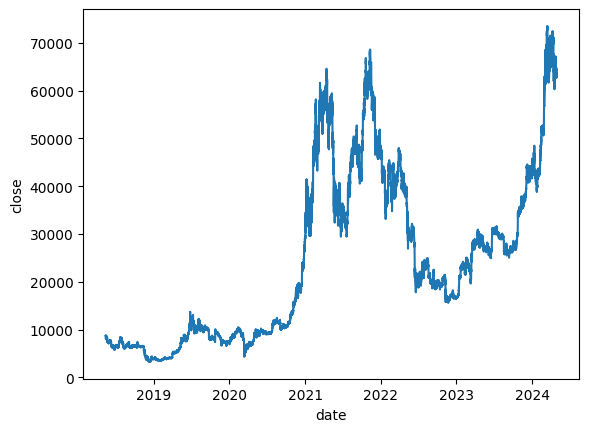

In [7]:
# Let's take a look at BTC before considering CCF with other coins.
ax = sns.lineplot(data=df_bitcoin, x='date', y='close')
plt.show()

In [10]:


btc_close = dct_coin_tables['BTC']['close'].to_numpy()
ether_close = dct_coin_tables['ETH']['close'].to_numpy()
btc_close_diff = np.diff(btc_close)
ether_close_diff = np.diff(ether_close)

# Ether starts later than BTC.
eth_start = dct_coin_tables['ETH']['date'].min()
mask_for_btc = dct_coin_tables['BTC']['date'] >= eth_start
btc_close = btc_close[mask_for_btc]

print('ADF Test Results:\nBTC: {} ---- df BTC: {}\nEther: {} ---- df ETHER: {}'.format(adfuller(btc_close), adfuller(btc_close_diff), adfuller(ether_close), adfuller(ether_close_diff)))
# test_corr = ccf(btc_close, ether_close)

ADF Test Results:
BTC: (-1.1287303017576162, 0.7034796878688182, 53, 35332, {'1%': -3.4305350949608577, '5%': -2.8616218074229254, '10%': -2.566813543515878}, 471213.19294254103) ---- df BTC: (-26.262276104042304, 0.0, 53, 35821, {'1%': -3.430532568009539, '5%': -2.8616206906069075, '10%': -2.5668129490638925}, 477267.8123220096)
Ether: (-1.120468944426226, 0.7068404868127686, 53, 35332, {'1%': -3.4305350949608577, '5%': -2.8616218074229254, '10%': -2.566813543515878}, 286053.60059502325) ---- df ETHER: (-25.769666574556535, 0.0, 52, 35332, {'1%': -3.4305350949608577, '5%': -2.8616218074229254, '10%': -2.566813543515878}, 286045.7635477395)
